In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import scale 
import seaborn as sns
from scipy.stats import norm

from matplotlib import style
style.use('ggplot')

In [2]:
# Functions
class Wheel():
    # A Roulette Wheel
    # Every turn() gives you a random result on the wheel 
    
    def __init__(self):
        self.choices = []
        for i in range(1, 37):
            for j in ['red', 'black']:
                self.choices.append((i,j))
            
        self.choices.append((0, 'green'))
        random.shuffle(self.choices) # Don't really need this but it looks nice ...
    
    def turn(self):
        return random.choice(self.choices)

def player(kitty=100, start=1, goes=100, till=0.5):
    # The player, visits the casino
    # starts off with a fixed kitty and bets the same
    # for the number of goes or until the kitty is empty
    # Each visit generates some statistics
    
    stats = []
    bet = start
    start_kitty = kitty
    
    keys = ['i', 'bet', 'turn', 'result', 'kitty']
    d = {}
    this_bet = start
    
    w = Wheel()
    
    for i in range(1, goes+1):
        
        t = w.turn()
        
        if t[1] == 'red':
            # if you win, take the winnings and bet the wager again
            kitty = kitty + bet
            # once you win go back to your initial small bet
            bet = start  
            d = {}
            values = [i, this_bet, t,  1,kitty]
            #p.append(dict(zip(keys, )))
            p = dict(zip(keys, values))
        else:
            # if you lose, double your wager and bet again
            kitty = kitty - bet
            bet = bet * 2
            values = [i, this_bet, t, 0,kitty]
            p = dict(zip(keys, values))
                        
        this_bet = bet
        stats.append(p)
        
        if (kitty < 0) or (kitty >= start_kitty * (1 + till)):
            break
        
    return stats


def get_player_stats(stats):
    # Consolidates a single visit statistics

    wins = 0
    loses = 0
    max_kitty = 0
    end_kitty = 0
    max_bet = 0
    blown = 0

    kitties = []
    bets = []

    for stat in stats:
        kitties.append(stat['kitty'])
        bets.append(stat['bet'])
        wins = wins + stat['result']

        if stat['result'] == 0:
            loses += 1
    max_kitty = np.max(kitties)
    max_bet = np.max(bets)

    if stats[-1]['kitty'] <= 0:
        blown = 1
    
    end_kitty = kitties[-1]

    keys = ['wins', 'loses', 'max_kitty', 'end_kitty', 'max_bet', 'blown']
    values = [wins, loses, max_kitty, end_kitty, max_bet, blown]
    return dict(zip(keys, values))

def get_team_stats(team_stats, kitty):
    # Consolidates multiple visits by multiple players
    
    wins_count = 0
    wins_amount = []
    wins_avg = 0
    blowns = 0    
    ev = 0
    num_plays = len(team_stats)

    for stat in team_stats:
        if stat['end_kitty'] <= 0:
            blowns += 1
        else:
            wins_amount.append(stat['end_kitty'])
            wins_count += 1
    
    wins_avg = np.mean(wins_amount) - kitty
    ev = ((wins_count / num_plays) * (wins_avg)) - ((blowns / num_plays) * kitty)
    keys = ['num_plays', 'kitty', 'wins_count', 'wins_avg', 'blowns', 'ev']
    values = [num_plays, kitty, wins_count, wins_avg, blowns, ev]
    
    return dict(zip(keys, values))
    

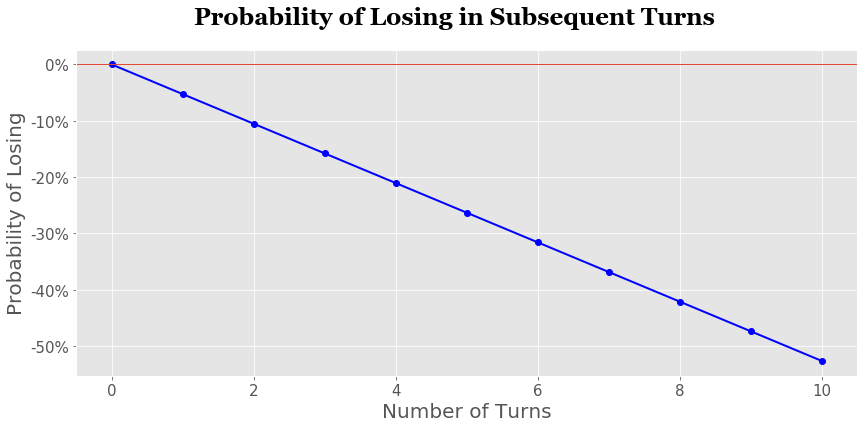

In [3]:
x = [0,]
y = [0,]

for i in range(1, 11):
    x.append(i)
    y.append(y[-1] + -2/38)

fig, ax = plt.subplots(figsize=(14,6))

fig.suptitle('Probability of Losing in Subsequent Turns', fontname='Georgia', fontsize=24, fontweight='bold')

ax.plot(x,y, marker='o', color='b', linewidth=2)
ax.set_xlabel('Number of Turns', fontsize=20)
ax.set_ylabel('Probability of Losing', fontsize=20)

ax.axhline(0, linewidth=1)
ax.set_yticklabels(['{:d}%'.format(int(i*100)) for i in ax.get_yticks()], fontsize=15)
ax.set_xticklabels(['{:d}'.format(int(i)) for i in ax.get_xticks()], fontsize=15)
fig.savefig('probability-of-losing.png')

In [4]:
# Bet on Red
# Running with defaults

kitty = 100
start = 1
goes = 100
till = 0.5
team_size = 1000

team_stats = []
# Apply this strategy to a large number of players
for v in range(team_size):
    team_stats.append(get_player_stats(player()))
    
s = get_team_stats(team_stats, kitty=kitty)


In [5]:
print('{:>20s} {:>14s}'.format('Stat', 'Value'))
print(35 * '-')
print('{:>20s} {:>14d}'.format('Number of Plays', s['num_plays']))
print('{:>20s} {:>14d}'.format('Amount in Bank', s['kitty']))
print('{:>20s} {:>14d}'.format('Number of Wins', s['wins_count']))
print('{:>20s} {:>14.2f}'.format('Average Wins', s['wins_avg']))
print('{:>20s} {:>14d}'.format('Blown the Bank', s['blowns']))
print('{:>20s} {:>14.2f}'.format('Expected Value', s['ev']))

                Stat          Value
-----------------------------------
     Number of Plays           1000
      Amount in Bank            100
      Number of Wins            736
        Average Wins          46.91
      Blown the Bank            264
      Expected Value           8.12


In [6]:
# Does the bank size matter?
ev = []
wins_count = []
blowns = []
wins_avg = []

x = []
for v in range(20,200):
    x.append(v)
    team_stats = []
    for i in range(team_size):
        team_stats.append(get_player_stats(player(kitty=v, start=1, goes=100, till=999)))
    
    overall_stats = get_team_stats(team_stats, kitty=v)
    
    ev.append(overall_stats['ev'])
    wins_count.append(overall_stats['wins_count'])
    blowns.append(overall_stats['blowns'])
    wins_avg.append(overall_stats['wins_avg'])

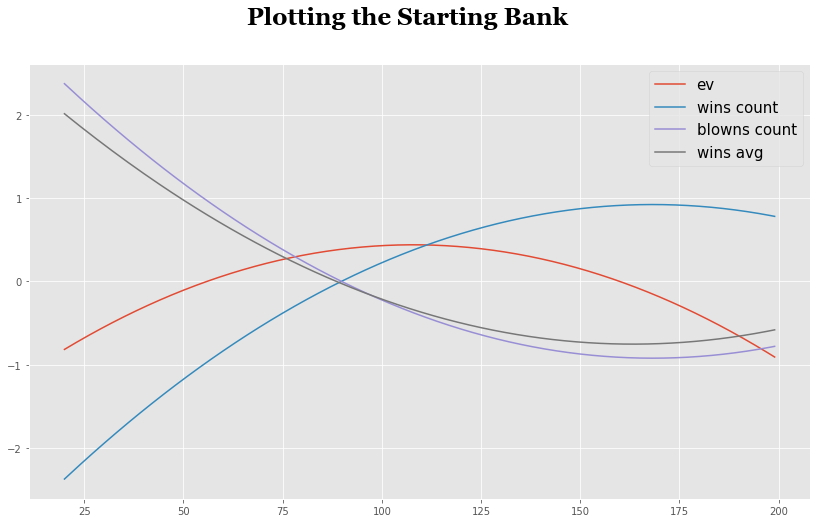

In [7]:
# Plotting bank size
fig, ax = plt.subplots(figsize=(14,8))
fig.suptitle("Plotting the Starting Bank", fontname='Georgia', fontsize=24, fontweight='bold')

a = scale(ev)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='ev')

a = scale(wins_count)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='wins count')

a = scale(blowns)
#x = list(range(len(a)))
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='blowns count')

a = scale(wins_avg)
#x = list(range(len(a)))
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='wins avg')

legend = ax.legend(fontsize=15)

plt.savefig('bank.png')

In [8]:
# Do the number of goes matter?
ev = []
wins_count = []
blowns = []
wins_avg = []

kitty = 140

x = []
for v in range(25,200):
    x.append(v)
    team_stats = []
    for i in range(team_size):
        team_stats.append(get_player_stats(player(kitty=kitty, start=1, goes=v, till=999)))
    
    overall_stats = get_team_stats(team_stats, kitty=kitty)
    
    ev.append(overall_stats['ev'])
    wins_count.append(overall_stats['wins_count'])
    blowns.append(overall_stats['blowns'])
    wins_avg.append(overall_stats['wins_avg'])

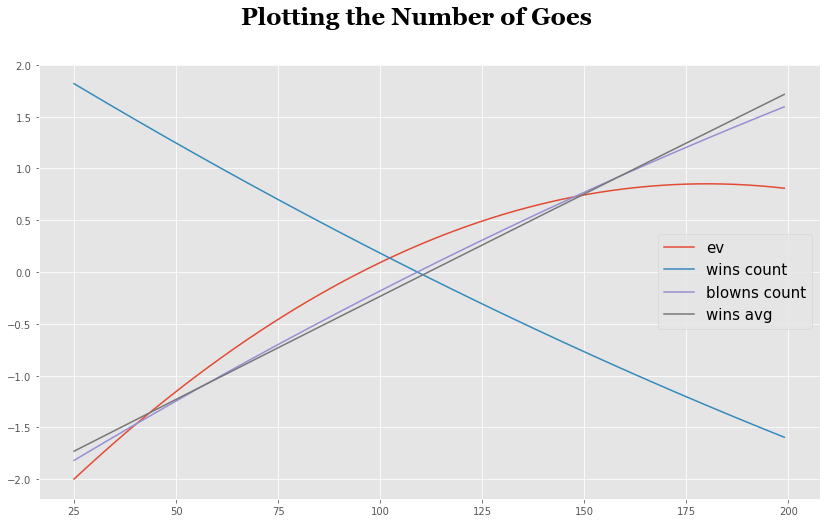

In [9]:
# Plot number of goes
fig, ax = plt.subplots(figsize=(14,8))

fig.suptitle("Plotting the Number of Goes", fontname='Georgia', fontsize=24, fontweight='bold')

a = scale(ev)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='ev')

a = scale(wins_count)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='wins count')

a = scale(blowns)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='blowns count')

a = scale(wins_avg)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='wins avg')

legend = ax.legend(fontsize=15)
plt.savefig('goes.png')

In [10]:
# Does finishing early matter?
ev = []
wins_count = []
blowns = []
wins_avg = []

kitty = 140
goes = 90

x = []
for v in np.linspace(0.1,1):
    x.append(v)
    team_stats = []
    for i in range(team_size):
        team_stats.append(get_player_stats(player(kitty=kitty, start=1, goes=goes, till=v)))
    
    overall_stats = get_team_stats(team_stats, kitty=kitty)
    
    ev.append(overall_stats['ev'])
    wins_count.append(overall_stats['wins_count'])
    blowns.append(overall_stats['blowns'])
    wins_avg.append(overall_stats['wins_avg'])

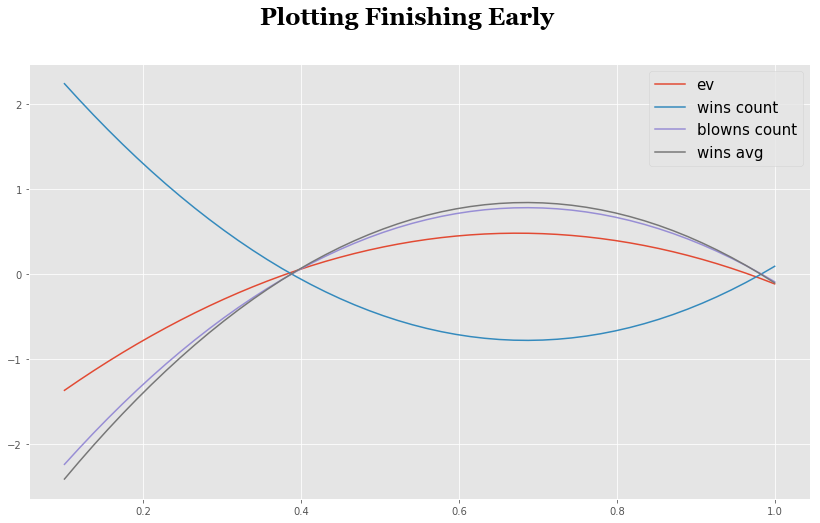

In [11]:
# Plotting finishing early
fig, ax = plt.subplots(figsize=(14,8))

fig.suptitle("Plotting Finishing Early", fontname='Georgia', fontsize=24, fontweight='bold')

a = scale(ev)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='ev')

a = scale(wins_count)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='wins count')

a = scale(blowns)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='blowns count')

a = scale(wins_avg)
z = np.polyfit(x,a,2)
p = np.poly1d(z)
ax.plot(x, p(x), label='wins avg')

legend = ax.legend(fontsize=15)
plt.savefig('till.png')

In [12]:
# Bet on Red
# Running with optimized numbers 

sim_stats = []

kitty = 140
sim_size = 1000
team_size = 1000
for i in range(sim_size):
    team_stats = []
    for j in range(team_size):
        team_stats.append(get_player_stats(player(kitty=kitty, start=1, goes=90, till=0.5)))

    sim_stats.append(get_team_stats(team_stats, kitty=kitty))

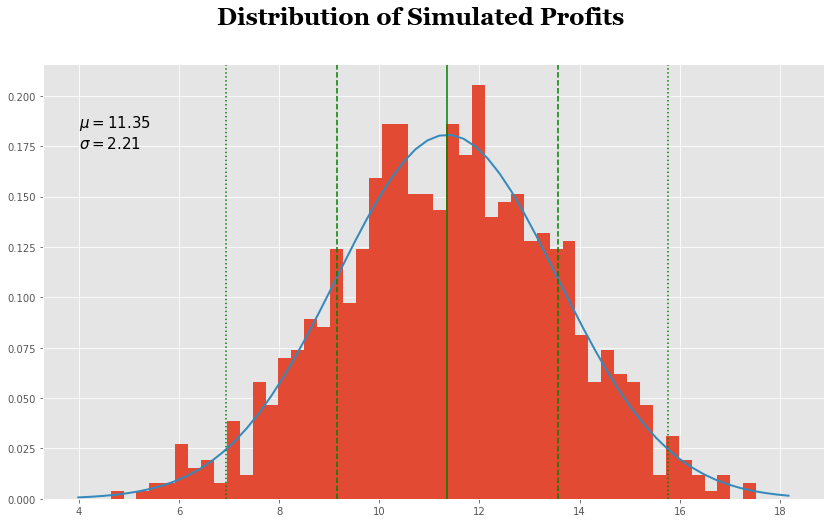

In [14]:
# How consistent is this

ev = []
for stat in sim_stats:
    ev.append(stat['ev'])

from scipy import stats

mu = np.mean(ev)
median = np.median(ev)
sigma = np.std(ev)

textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\sigma=%.2f$' % (sigma, )))
#sns.text(txtstr)

density = stats.kde.gaussian_kde(ev)

fig, ax = plt.subplots(figsize=(14,8))
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.suptitle('Distribution of Simulated Profits', fontname='Georgia', fontsize=24, fontweight='bold')
ax.hist(ev, bins=50, density=True)

# Draw curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, mu, sigma)
ax.plot(x, p, linewidth=2)

ax.axvline(mu, color='green', linestyle='-')
ax.axvline(mu + sigma, color='green', linestyle='--')
ax.axvline(mu - sigma, color='green', linestyle='--')
ax.axvline(mu + (sigma * 2), color='green', linestyle=':')
ax.axvline(mu - (sigma * 2), color='green', linestyle=':')
ax.text(4, 0.175, textstr, fontsize=15)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.savefig("normal.png")